This example provides a simple case that shows a typical workflow to find the optimal configurations (i.e. data) and the corresponding weights using the information-matching method.
A common step-by-step workflow looks like the following:
1. Define the model, the candidate configurations or data, and the target QoIs we want to predict and their precision.
2. Compute the FIM for each candidate configuration and the FIM of the target quantities
3. Solve a convex optimization problem to match the FIMs
4. Propagate the uncertainties to the target quantities

In the case of active learning, where we also aim to infer the optimal parameters, we can put steps 2 and 3 in a loop.

In [1]:
import numpy as np

from information_matching.fim import FIM_nd
from information_matching import ConvexOpt

# For plotting
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use("default")

# Define the models

As a toy example, we will consider the weather modeling problem.
We look at the data of monthly averaged atmospheric pressure difference between Easter Island and Darwin, Australia.
The data contains an annual cycle and other cycles that correspond to the El Niño and Southern Oscillation.

In [2]:
# Load the atmospheric pressure data
data = np.loadtxt("ENSO.txt")
time, press = data.T

We model this phenomena with the following model as a function of time in month:
\begin{equation}
    \begin{aligned}
        y(t; \theta) =&~ \theta_1 +
            \theta_2 \cos(2\pi t/12) + \theta_3 \sin(2\pi t/12) + \\
            &~ \theta_5 \cos(2\pi t/\theta_4) + \theta_6 \sin(2\pi t/\theta_4) + \\
            &~ \theta_8 \cos(2\pi t/\theta_7) + \theta_9 \sin(2\pi t/\theta_7).
    \end{aligned}
\end{equation}
Notice that the first two Fourier terms with period of 12 months to capture the annual cycle.
The other terms correspond to two other cycles, which according to previous training, have periods of around 2 and 4 years.

Optimal parameters: [10.51075089  3.07621084  0.53279973 44.31121293 -1.62312733  0.52557742
 26.88775238  0.21244653  1.49666883]


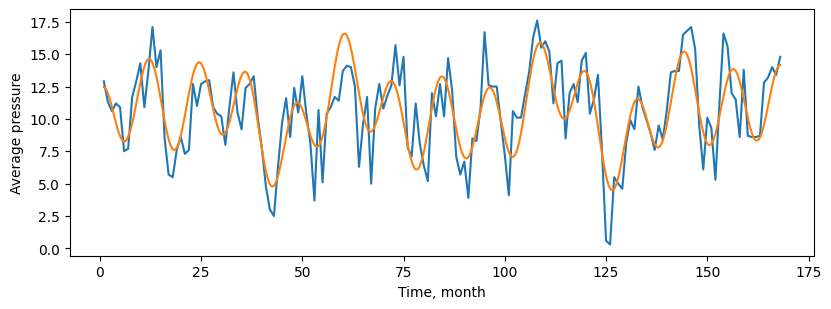

In [3]:
# Defining the model.
# The model take parameter array as the first input and output a prediction array
def y(theta, t=time):
    """Model"""
    th1, th2, th3, th4, th5, th6, th7, th8, th9 = theta

    term1 = th1
    term2 = th2 * np.cos(2 * np.pi * t / 12)
    term3 = th3 * np.sin(2 * np.pi * t / 12)
    term4 = th5 * np.cos(2 * np.pi * t / th4)
    term5 = th6 * np.sin(2 * np.pi * t / th4)
    term6 = th8 * np.cos(2 * np.pi * t / th7)
    term7 = th9 * np.sin(2 * np.pi * t / th7)
    return term1 + term2 + term3 + term4 + term5 + term6 + term7


# These optimal parameters come from previous training
theta_best = np.loadtxt("optimal_parameters.txt")
nparams = len(theta_best)
print("Optimal parameters:", theta_best)

# Plot the best model
tfine = np.linspace(*time[[0, -1]], 1000)
plt.figure(figsize=(9.6, 3.2))
plt.plot(time, press)
plt.plot(tfine, y(theta_best, tfine), label="Model")
plt.xlabel("Time, month")
plt.ylabel("Average pressure")
plt.show()

For this example, we target to precisely predict the atmospheric pressure in the 15th year.
Since the quantities we want to predict is the same as the training quantity, we can still use the training model $y(t; \theta)$ to predict the target quantities.
We will try to predict this quantity within 2~atm.

In [4]:
# Target predictions
time_target = np.arange(12 * 14, 12 * 15) + 1
std_target = 2  # Target uncertainty of the target prediction

We will use these 14 years worth of atmospheric data and predict the pressure in the following year.
We ask about the data corresponding to which years that contain the most information to predict the pressure in the 15th year.
Thus, the candidate configurations will be the observations in each year.

In [5]:
# Candidate configurations
configs = {
    f"year_{ii+1}": {"time": tlist} for ii, tlist in enumerate(time.reshape((-1, 12)))
}

# Compute the FIMs

To find the most informative year using the information-matching approach, we need to compute the FIM for each candidate configuration, i.e. each year, and the target FIM computed for the 15th year.
Then, let's say that we want to make the predictions within 2 atm.

In [6]:
# Compute the FIM of the candidate configurations
fim_configs = {
    config_id: FIM_nd(y)(theta_best, t=config_info["time"])
    for config_id, config_info in configs.items()
}

# Compute the target FIM
fim_target = FIM_nd(y)(theta_best, t=time_target) / std_target ** 2

# Solve convex optimization problem

Now, we are ready to find the optimal configurations using the information-matching method.
Additionally, we will also obtain the optimal weights for those optimal configurations, which set the target standard deviation we should achieve when collecting the data for those configurations.

In [7]:
# Convex optimization to find the optimal configurations and weights
cvxopt = ConvexOpt(fim_target, fim_configs)
cvxopt.solve()

# These how we get the optimal results
opt_configs = cvxopt.get_config_weights()
print("Optimal configuration and weights:")
print("Configuration \t Weight \t Standard deviation")
for config, weight in opt_configs.items():
    print(f"{config}  \t {weight:0.4f} \t {1/np.sqrt(weight):0.4f}")

Strange behavior : primal < dual :: line 158 in sdpa_solve.cpp
Optimal configuration and weights:
Configuration 	 Weight 	 Standard deviation
year_1  	 0.2090 	 2.1872
year_3  	 0.0238 	 6.4776
year_8  	 0.0861 	 3.4086
year_10  	 0.0696 	 3.7896
year_11  	 0.4445 	 1.4999
year_13  	 0.1195 	 2.8927
year_14  	 0.3407 	 1.7132


/home/yonatank/.local/lib/python3.10/site-packages/cvxpy/problems/problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


One way we can represent this result is to plot the target accuracy in data collection and superimpose this information on top of the plot of data and best model that is shown above.
So, in the following plot, the target data accuracy from the optimal information-matching result is shown as gray envelop around the best model.
Notice that the data that we have turn out to satisfy this requirement pretty well.

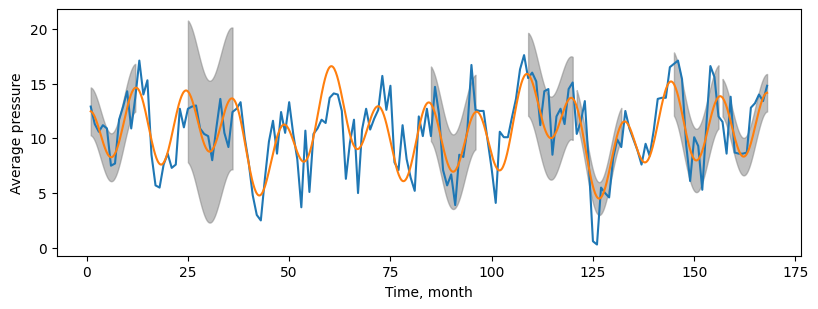

In [8]:
plt.figure(figsize=(9.6, 3.2))
# Plot the data
plt.plot(time, press)
# Plot the best model
tfine = np.linspace(*time[[0, -1]], 1000)
plt.plot(tfine, y(theta_best, tfine), label="Model")

# Plot the target data accuracy of the optimal configurations
for config, weight in opt_configs.items():
    std_config = 1 / np.sqrt(weight)
    tlist = configs[config]["time"]
    tfine_config = np.linspace(*tlist[[0, -1]], 100)
    preds_config = y(theta_best, tfine_config)
    plt.fill_between(
        tfine_config,
        preds_config - std_config,
        preds_config + std_config,
        color="gray",
        alpha=0.5,
    )

plt.xlabel("Time, month")
plt.ylabel("Average pressure")
plt.show()

# Uncertainty propagation

In theory, the observations from these 7 years already contain sufficient information to predict the pressure in the 15th year within 2 atm.
We will check this theory by quantifying the uncertainty of the target predictions using these optimal configurations.
Note that we will use a linear approximation of the uncertainty.

In [9]:
# Compare the results
# First, let's compute the FIM only using these optimal configurations
opt_fim_configs = np.zeros((nparams, nparams))
for config, weight in opt_configs.items():
    opt_fim_configs += fim_configs[config] * weight

# Propagate the uncertainty to the target predictions of pressure in the 15th year
cov_params = np.linalg.inv(opt_fim_configs)
jac_target = FIM_nd(y).Jacobian(theta_best, t=time_target)
cov_target = jac_target @ cov_params @ jac_target.T
opt_std_target = np.sqrt(np.diag(cov_target))
print("Standard deviation of the predictions in the 15th year:")
print(opt_std_target)

Standard deviation of the predictions in the 15th year:
[0.72903737 0.73904968 0.74727548 0.75754497 0.77546797 0.80163266
 0.82632162 0.83399889 0.81615363 0.78561066 0.7834227  0.85757286]


As expected, the uncertainty of the target from the optimal configurations and weights are smaller than the predefined target uncertainty.
Another way to view it is to plot the result.
In the following, we plot the predictions (red curve) with the target uncertainty to achieve (red envelop) and the uncertainty from the optimal configurations (red error bars).
We can clearly see that the uncertainty from the optimal configurations are smaller than the target uncertainty to achieve.

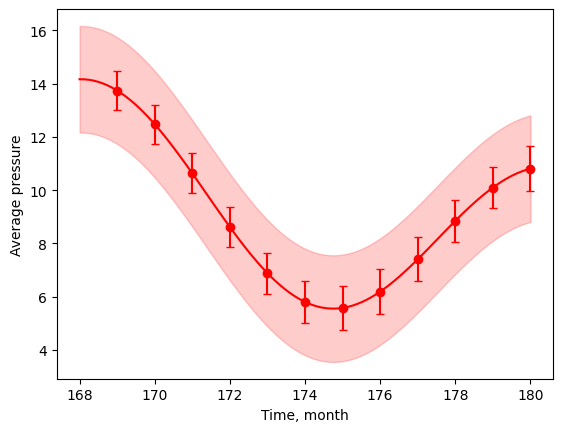

In [10]:
plt.figure()
# Plot the target predictions
tfine_target = np.linspace(12 * 14, 12 * 15, 100)
preds_target = y(theta_best, tfine_target)
plt.plot(tfine_target, preds_target, c="r")
# Plot the target uncertainty that we want to achieve
plt.fill_between(
    tfine_target,
    preds_target - std_target,
    preds_target + std_target,
    color="r",
    alpha=0.2,
)
# Plot the uncertainty obtained from the optimal configurations and weights
plt.errorbar(
    time_target,
    y(theta_best, time_target),
    opt_std_target,
    fmt="o",
    color="r",
    capsize=3,
)

plt.xlabel("Time, month")
plt.ylabel("Average pressure")
plt.show()